<a href="https://colab.research.google.com/github/MustofAhmed41/4-Wheel-Drive-Proteus/blob/master/Updated_PreProcessing_Thesis_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from collections import Counter

In [83]:
df2 = pd.read_excel('thesis_dataset.xlsx')

In [84]:
df = df2.copy()

In [85]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    return (c * r)


# driver code
lat1 = 23.7188605
lat2 = 23.8692984
lon1 = 90.3859656
lon2 = 90.3991897

print(distance(lat1, lat2, lon1, lon2), "K.M")


16.78195346510548 K.M


In [86]:
df['Distance_Travelled'] = np.nan
df['Movement'] = 'STATIONARY'
df['Date_Time'] =  pd.to_datetime(df['Date_Time'])
df['Elapsed_Time'] = np.nan
df['Speed'] = np.nan
df['Home_Stay'] = 'Unknown'
df['Total_Distance_Travelled'] = np.nan
df['Number_Of_clusters'] = 0

In [87]:
def calculate_speed(dist_time):
    dist = dist_time[0]
    time = dist_time[1]
    if time is 0:
      return 0
    else:
      return dist/time

In [88]:
zero = 0
nonzero = 0
prev_time = 0
for i in df['UserId'].unique():
  sensorgps_lat = sensorgps_long = 0
  for  z, x, y, t in df[df['UserId'] == i ][['Unnamed: 0','SENSORGPS_LATITUDE','SENSORGPS_LONGITUDE', 'Date_Time']].itertuples(index=False):
    if (x == 0 and y == 0) or ( sensorgps_lat==0 and sensorgps_long == 0):
      sensorgps_lat = x
      sensorgps_long = y   
      prev_time = t      
      df.loc[z,'Distance_Travelled'] = 0  
      df.loc[ df['Unnamed: 0'] == z,'Movement'] = 'STATIONARY'    
      df.loc[ df['Unnamed: 0'] == z,'Elapsed_Time'] = 100
      df.loc[ df['Unnamed: 0'] == z,'Speed'] = 0  
    else:
      dist = distance(sensorgps_lat, x, sensorgps_long,y)
      df.loc[z,'Distance_Travelled'] = dist  
      duration_in_s = (t - prev_time).total_seconds()      
      if duration_in_s != 0 :
        df.loc[ df['Unnamed: 0'] == z,'Elapsed_Time'] = duration_in_s / 3600  
      else:
        df.loc[ df['Unnamed: 0'] == z,'Elapsed_Time'] = 100

      prev_time = t
      if dist == 0:
        zero += 1
        df.loc[ df['Unnamed: 0'] == z,'Movement'] = 'STATIONARY'
      else:
        nonzero += 1
        df.loc[df['Unnamed: 0'] == z,'Movement'] = 'MOVING'
      sensorgps_lat = x
      sensorgps_long = y

print(zero, nonzero)

df['Speed'] = df.Distance_Travelled / df.Elapsed_Time

15812 1608


In [89]:
df['Elapsed_Time'].value_counts()

100.000000    6067
0.250000      3607
0.250278       370
0.250556       141
0.021389        99
              ... 
0.971944         1
2.895833         1
1.900000         1
1.632500         1
5.626944         1
Name: Elapsed_Time, Length: 4057, dtype: int64

In [90]:
df['Accelerometer'] = (df.ACCELEROMETER_X ** 2 + df.ACCELEROMETER_Y ** 2 + df.ACCELEROMETER_Z ** 2) ** (1/2)

In [ ]:
# zero = 0
# home_stay = []
# for i in df['UserId'].unique():
#   count = 0
#   home_location = []
#   for  x, y, lat, lon in df[df['UserId'] == i][['Unnamed: 0','Date_Time', 'SENSORGPS_LATITUDE','SENSORGPS_LONGITUDE' ]].itertuples(index=False):    
#     hour_second = y.strftime('%H:%M')
#     hour = int(hour_second[0:2])
    
#     if hour >= 0 and hour <= 6:      
#       home_location.append( (lat, lon) )
#       #(str(lat), str(lon))

#   c1 = Counter(home_location)  
#   if len(c1) > 0:
#     print(c1, ' : ',c1.most_common()[0], c1.most_common()[0][0])
#   else:
#     print('homeless')


In [ ]:
zero = 0
home_stay = []
for i in df['UserId'].unique():
  count = 0
  home_location = []
  for  x, y, lat, lon in df[df['UserId'] == i][['Unnamed: 0','Date_Time', 'SENSORGPS_LATITUDE','SENSORGPS_LONGITUDE' ]].itertuples(index=False):    
    hour_second = y.strftime('%H:%M')
    hour = int(hour_second[0:2])
    if hour >= 0 and hour <= 6:
      home_location.append( (lat, lon) )
  
  c1 = Counter(home_location)
  
  if len(c1) > 0:
    for  z, lat, lon in df[df['UserId'] == i][['Unnamed: 0', 'SENSORGPS_LATITUDE','SENSORGPS_LONGITUDE' ]].itertuples(index=False):
      if c1.most_common()[0][0] == (lat, lon):
        df.loc[ df['Unnamed: 0'] == z,'Home_Stay'] = 'Home'
      else:
        df.loc[ df['Unnamed: 0'] == z,'Home_Stay'] = 'Outside'


In [ ]:
print(df['Date_Time'].dt.strftime('%H:%M'))

0        22:16
1        22:31
2        23:17
3        23:40
4        23:55
         ...  
22846    21:28
22847    21:43
22848    21:05
22849    21:20
22850    21:40
Name: Date_Time, Length: 22851, dtype: object


In [ ]:
for i in df['UserId'].unique():
   df.loc[ (df['UserId'] == i)  , 'Total_Distance_Travelled'] =  sum(df[df['UserId'] ==i ]['Distance_Travelled'])

In [ ]:
for i in df['UserId'].unique():
   df.loc[ (df['UserId'] == i) ,
          'SENSORGPS_LATITUDE_VARIANCE'] =  np.var( df[(df['UserId'] == i) & (df['Movement'] == 'STATIONARY') &
          (df['SENSORGPS_LATITUDE'] != 0) & (df['SENSORGPS_LONGITUDE']  != 0) ]['SENSORGPS_LATITUDE'])

for i in df['UserId'].unique():
   df.loc[ (df['UserId'] == i) ,
          'SENSORGPS_LONGITUDE_VARIANCE'] =  np.var( df[(df['UserId'] == i) & (df['Movement'] == 'STATIONARY') &
          (df['SENSORGPS_LATITUDE'] != 0) & (df['SENSORGPS_LONGITUDE']  != 0) ]['SENSORGPS_LONGITUDE'])

df['Location_Variance'] = (df['SENSORGPS_LATITUDE_VARIANCE'] + df['SENSORGPS_LONGITUDE_VARIANCE'])

In [ ]:

for i in df['UserId'].unique():
  clusters_tracker = []
  for  lat, lon in df[df['UserId'] == i][['SENSORGPS_LATITUDE','SENSORGPS_LONGITUDE' ]].itertuples(index=False): 
    if lat != 0 and lon != 0:   
      clusters_tracker.append( (lat, lon) )        
  c1 = Counter(clusters_tracker)
  possible_clusters = []
  for j in c1.most_common():
    if j[1] > 9:
      possible_clusters.append(j[0])
  
  #print(possible_clusters)
  
  updated_clusters = []

  for x in possible_clusters:
    for y in possible_clusters:
      if x != y and (x, y) not in updated_clusters and (y, x) not in updated_clusters :
        updated_clusters.append( (x, y , distance(x[0],y[0], x[1], y[1]) ))
        #print(x, y, distance(x[0],y[0], x[1], y[1]) )
  
  filtered_clusters = []

  for x in updated_clusters:
    if x[2] <= 0.02 and x[1] not in filtered_clusters and x[0] not in filtered_clusters:
      filtered_clusters.append(x[1])
      #print(x[1])

  print('Before Removal : ', updated_clusters)

  for x in filtered_clusters:
    for k, y in enumerate(updated_clusters):
      if x == y[0] or x == y[1]:
        updated_clusters.pop(k)
  print(filtered_clusters)
  print('After Removal : ', updated_clusters)

  print('\n\n\n')
  
  df.loc[ (df['UserId'] == i)  , 'Number_Of_clusters'] =  len(updated_clusters) + 1




Before Removal :  [((23.8317, 90.4187), (23.8317, 90.4186), 0.010171403117188026), ((23.8317, 90.4186), (23.8317, 90.4187), 0.010171403117188026)]
[(23.8317, 90.4186)]
After Removal :  [((23.8317, 90.4186), (23.8317, 90.4187), 0.010171403117188026)]




Before Removal :  [((23.8369, 90.3737), (23.7443, 90.4093), 10.91517690254816), ((23.8369, 90.3737), (23.7638, 90.4068), 8.798319967205494), ((23.8369, 90.3737), (23.7443, 90.4094), 10.918557535613159), ((23.7443, 90.4093), (23.8369, 90.3737), 10.91517690254816), ((23.7443, 90.4093), (23.7638, 90.4068), 2.183178359316544), ((23.7443, 90.4093), (23.7443, 90.4094), 0.010178244749519694), ((23.7638, 90.4068), (23.8369, 90.3737), 8.798319967205494), ((23.7638, 90.4068), (23.7443, 90.4093), 2.183178359316544), ((23.7638, 90.4068), (23.7443, 90.4094), 2.1843878747520744), ((23.7443, 90.4094), (23.8369, 90.3737), 10.918557535613159), ((23.7443, 90.4094), (23.7443, 90.4093), 0.010178244749519694), ((23.7443, 90.4094), (23.7638, 90.4068), 2.1843

In [ ]:
df.to_excel('test.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22851 entries, 0 to 22850
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     22851 non-null  int64         
 1   UserId                         22851 non-null  object        
 2   Entry_Id                       22851 non-null  object        
 3   Age                            22851 non-null  object        
 4   Gender                         22851 non-null  object        
 5   University                     22851 non-null  object        
 6   ACCELEROMETER_X                22851 non-null  float64       
 7   ACCELEROMETER_Y                22851 non-null  float64       
 8   ACCELEROMETER_Z                22851 non-null  float64       
 9   BATTERY_LEVEL                  22189 non-null  float64       
 10  Date_Time                      22851 non-null  datetime64[ns]
 11  Light_v        

In [ ]:
# for i in df['UserId'].unique():
#    # print(df[ (df['UserId'] == i) & (df['Movement'] == 'STATIONARY') &
#           #(df['SENSORGPS_LATITUDE'] != 0) & (df['SENSORGPS_LONGITUDE']  != 0) ].var()['SENSORGPS_LATITUDE'])


In [ ]:
# import pandas as pd

# # Create your Pandas DataFrame
# d = {'username': ['Alice', 'Bob', 'Carl', 'catty'],
#      'age': [18, 22, 43, 20],
#      'income': [100000, 98000, 111000, 50000]}
# df = pd.DataFrame(d)

# print(df)

# print(df.var())

# print(df.var()['income'])
# print(df.var()['age'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22851 entries, 0 to 22850
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     22851 non-null  int64         
 1   UserId                         22851 non-null  object        
 2   Entry_Id                       22851 non-null  object        
 3   Age                            22851 non-null  object        
 4   Gender                         22851 non-null  object        
 5   University                     22851 non-null  object        
 6   ACCELEROMETER_X                22851 non-null  float64       
 7   ACCELEROMETER_Y                22851 non-null  float64       
 8   ACCELEROMETER_Z                22851 non-null  float64       
 9   BATTERY_LEVEL                  22189 non-null  float64       
 10  Date_Time                      22851 non-null  datetime64[ns]
 11  Light_v        

In [ ]:
df['Date_Time'] =  pd.to_datetime(df['Date_Time'])

In [ ]:
print(df['Date_Time'])

0       2022-03-08 22:16:11
1       2022-03-08 22:31:55
2       2022-03-08 23:17:02
3       2022-03-08 23:40:38
4       2022-03-08 23:55:38
                ...        
22846   2022-03-05 21:28:50
22847   2022-03-05 21:43:50
22848   2022-03-26 21:05:02
22849   2022-03-26 21:20:02
22850   2022-03-26 21:40:37
Name: Date_Time, Length: 22851, dtype: datetime64[ns]


In [ ]:
print(df['Date_Time'].dt.strftime('%H:%M'))

0        22:16
1        22:31
2        23:17
3        23:40
4        23:55
         ...  
22846    21:28
22847    21:43
22848    21:05
22849    21:20
22850    21:40
Name: Date_Time, Length: 22851, dtype: object


In [ ]:
then = datetime(2012, 3, 5, 23, 8, 15)
now  = datetime.now() 
duration = now - then                         # For build-in functions
duration_in_s = duration.total_seconds()   
print(duration_in_s)
print()
hours = divmod(duration_in_s, 3600)[0]
print(hours)

322850740.604948

89680.0


###filling null values with 0

In [ ]:
df.isnull().sum(axis = 0)

Unnamed: 0               0
UserId                   0
Entry_Id                 0
Age                      0
Gender                   0
University               0
ACCELEROMETER_X          0
ACCELEROMETER_Y          0
ACCELEROMETER_Z          0
BATTERY_LEVEL          662
Date_Time                0
Light_v                  0
GRAV_X                   0
GRAV_Y                   0
GRAV_Z                   0
GYROSCOPE_X              0
GYROSCOPE_Y              0
GYROSCOPE_Z              0
MAG_X                    0
MAG_Y                    0
MAG_Z                    0
ORIENTATION_AZIMUTH      0
ORIENTATION_PITCH        0
ORIENTATION_ROLL         0
SENSORGPS_LATITUDE       0
SENSORGPS_LONGITUDE      0
Email Address            0
PHQ-Label                0
dtype: int64

In [ ]:
df.fillna(0, inplace = True)
print()

In [ ]:
df.isnull().sum(axis = 0)

Unnamed: 0             0
UserId                 0
Entry_Id               0
Age                    0
Gender                 0
University             0
ACCELEROMETER_X        0
ACCELEROMETER_Y        0
ACCELEROMETER_Z        0
BATTERY_LEVEL          0
Date_Time              0
Light_v                0
GRAV_X                 0
GRAV_Y                 0
GRAV_Z                 0
GYROSCOPE_X            0
GYROSCOPE_Y            0
GYROSCOPE_Z            0
MAG_X                  0
MAG_Y                  0
MAG_Z                  0
ORIENTATION_AZIMUTH    0
ORIENTATION_PITCH      0
ORIENTATION_ROLL       0
SENSORGPS_LATITUDE     0
SENSORGPS_LONGITUDE    0
Email Address          0
PHQ-Label              0
dtype: int64

###filling latitude and longitude

In [ ]:
print(df.isin([0]).sum(axis=0)['SENSORGPS_LATITUDE'])
print(df.isin([0]).sum(axis=0)['SENSORGPS_LONGITUDE'])

5315
5315


In [ ]:
mean_gps_lat_by_phq =  df[df['SENSORGPS_LATITUDE'] != 0].groupby('PHQ-Label').mean()['SENSORGPS_LATITUDE']
mean_gps_lat_by_phq

PHQ-Label
Mild                 23.690431
Moderate             23.768902
Moderately Severe    23.765290
None                 23.766311
Severe               23.804594
Name: SENSORGPS_LATITUDE, dtype: float64

In [ ]:
mean_latitude_dict = {'Mild' : 23.690431, 'Moderate': 23.768879, 'Moderately Severe': 23.765290,  'None' :23.766311, 'Severe': 23.804594  }

In [ ]:
user_lst = df['UserId'].unique()
mean_gps_lat_by_id =  df.groupby('UserId').mean()['SENSORGPS_LATITUDE']
missing_gps = 0
for i in range(len(mean_gps_lat_by_id)):
  if mean_gps_lat_by_id[i] == 0:    
    missing_gps += 1
    label = df[df['UserId'] == user_lst[i]].iloc[[0]]['PHQ-Label'] 
    for j in label:
      df.loc[ df['UserId'] == user_lst[i] , 'SENSORGPS_LATITUDE'] = mean_latitude_dict[j]

print('Fully missing GPS for ',  missing_gps , ' number of users' )
    

Fully missing GPS for  9  number of users


In [ ]:
user_lst = df['UserId'].unique()
mean_gps_lat_by_id =  df.groupby('UserId').mean()['SENSORGPS_LONGITUDE']
for i in range(len(mean_gps_lat_by_id)):
  if mean_gps_lat_by_id[i] == 0:    
    label = df[df['UserId'] == user_lst[i]].iloc[[0]]['PHQ-Label'] 
    for j in label:
      df.loc[ df['UserId'] == user_lst[i] , 'SENSORGPS_LONGITUDE'] = mean_latitude_dict[j]

### Removing invalid samples which contains 3 zeros

In [ ]:
col_combinations = [['ACCELEROMETER_X', 'ACCELEROMETER_Y', 'ACCELEROMETER_Z'],
                    ['GRAV_X', 'GRAV_Y', 'GRAV_Z'],
                    [ 'GYROSCOPE_X', 'GYROSCOPE_Y', 'GYROSCOPE_Z'],
                    ['MAG_X', 'MAG_Y', 'MAG_Z'],
                    ['ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL']                    
                    ]

In [ ]:
for i in col_combinations:
    print(i, ' : ' ,len(df))
    many_missing_values_in_row = df.index[ (df[i[0]] == 0) & (df[i[1]] == 0)  & (df[i[2]] == 0) ]
    df.drop(many_missing_values_in_row, inplace = True)
    print(i, ' : ' ,len(df))

['ACCELEROMETER_X', 'ACCELEROMETER_Y', 'ACCELEROMETER_Z']  :  22851
['ACCELEROMETER_X', 'ACCELEROMETER_Y', 'ACCELEROMETER_Z']  :  22851
['GRAV_X', 'GRAV_Y', 'GRAV_Z']  :  22851
['GRAV_X', 'GRAV_Y', 'GRAV_Z']  :  20354
['GYROSCOPE_X', 'GYROSCOPE_Y', 'GYROSCOPE_Z']  :  20354
['GYROSCOPE_X', 'GYROSCOPE_Y', 'GYROSCOPE_Z']  :  19608
['MAG_X', 'MAG_Y', 'MAG_Z']  :  19608
['MAG_X', 'MAG_Y', 'MAG_Z']  :  19604
['ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL']  :  19604
['ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL']  :  19604


##Filling battery level

In [ ]:
df.isin([0]).sum(axis=0)['BATTERY_LEVEL']

648

In [ ]:
mean_battery = []
mean_battery =  df[df['BATTERY_LEVEL'] != 0 ].groupby('UserId').mean()['BATTERY_LEVEL']
mean_battery

UserId
34aHCNx4fvb5pyE4mPdbGTMXjPb2    46.017241
38IyoUCxjrgfy2x7iBtLxh5JzJD3    64.167785
3MAuKqHZMcMB2vleHN69cmViXqx2    37.038961
4MKR0oR9fpfrJ9I91NiiDB4Pv2h2    71.736842
5iytFliuAMh2mrcNXzqIeQJsc3B2    38.549020
                                  ...    
vdtqKbkDWqQNBYpLRMkbJN1Ayad2    64.200000
vot9lSsMp4ew2qiwv4Co0Q6NIRV2    44.384615
wkghurEYpCfdqbRu0E0oEXqDfN32    39.809524
xbvMRucuWqPB4sHR57IpNwq5nri2    24.250000
yUTDHaNdmRYIBsyC36KhvnpgQnv2    85.000000
Name: BATTERY_LEVEL, Length: 71, dtype: float64

In [ ]:
count = 0
for i in df['UserId'].unique():
  df.loc[ (df['BATTERY_LEVEL'] == 0) & (df['UserId'] == i) , 'BATTERY_LEVEL'] = mean_battery[count]
  count += 1

In [ ]:
df.isin([0]).sum(axis=0)['BATTERY_LEVEL']

0

##filling Sensor Latitude and Longitude with all 0

In [ ]:
print(df.isin([0]).sum(axis=0)['SENSORGPS_LATITUDE'])
print(df.isin([0]).sum(axis=0)['SENSORGPS_LONGITUDE'])

3690
3690


In [ ]:
mean_gps_lat = []
mean_gps_lat =  df[df['SENSORGPS_LATITUDE'] != 0 ].groupby('UserId').mean()['SENSORGPS_LATITUDE']
count = 0
for i in df['UserId'].unique():
  df.loc[ (df['SENSORGPS_LATITUDE'] == 0) & (df['UserId'] == i) , 'SENSORGPS_LATITUDE'] = mean_gps_lat[count]
  count += 1

In [ ]:
mean_gps_long = []
mean_gps_long =  df[df['SENSORGPS_LONGITUDE'] != 0 ].groupby('UserId').mean()['SENSORGPS_LONGITUDE']
count = 0

for i in df['UserId'].unique():
  df.loc[ (df['SENSORGPS_LONGITUDE'] == 0) & (df['UserId'] == i) , 'SENSORGPS_LONGITUDE'] = mean_gps_long[count]
  count += 1

##removing samples that still contains more than 5 zeros

In [ ]:
print(len(df))
many_missing_values_in_row = df.index[((df == 0).sum(axis=1) >= 5) ]
df.drop(many_missing_values_in_row, inplace = True)
print(len(df))

19604
19434


In [ ]:
df['Age'].value_counts()

21-25    18942
25+        445
18-20       47
Name: Age, dtype: int64

In [ ]:
def impute_age(x):
  if x == '18-20':
    return 19
  elif x == '21-25':
    return 22.5
  elif x == '25+':
    return 27.5

In [ ]:
df['Age'] = df['Age'].apply(impute_age)

In [ ]:
df = pd.get_dummies(df, columns=['Gender'])

In [ ]:
df.head(5)

,Unnamed: 0,UserId,Entry_Id,Age,University,ACCELEROMETER_X,ACCELEROMETER_Y,ACCELEROMETER_Z,BATTERY_LEVEL,Date_Time,...,MAG_Z,ORIENTATION_AZIMUTH,ORIENTATION_PITCH,ORIENTATION_ROLL,SENSORGPS_LATITUDE,SENSORGPS_LONGITUDE,Email Address,PHQ-Label,Gender_Female,Gender_Male
0,0,34aHCNx4fvb5pyE4mPdbGTMXjPb2,-Mxeba-fS5VQrjM-w03M,22.5,Others,-3.511770,5.972490,6.99871,25.0,"Mar 8, 2022 10:16:11 PM",...,-35.1970,0.875866,-0.651602,0.465065,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
1,1,34aHCNx4fvb5pyE4mPdbGTMXjPb2,-Mxeba-sabBVXPeVIuBT,22.5,Others,-0.175872,3.080760,8.74457,24.0,"Mar 8, 2022 10:31:55 PM",...,-29.1702,-0.615485,-0.338664,0.000000,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
2,2,34aHCNx4fvb5pyE4mPdbGTMXjPb2,-Mxeba-yVuJIk8rhM7GJ,22.5,Others,2.298610,0.246461,9.57129,21.0,"Mar 8, 2022 11:17:02 PM",...,0.3538,1.713230,0.000000,-0.235693,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
3,3,34aHCNx4fvb5pyE4mPdbGTMXjPb2,-Mxfcw4dGPTMYQqotSLf,22.5,Others,0.208176,8.001000,5.88275,19.0,"Mar 8, 2022 11:40:38 PM",...,-0.0976,-2.862400,-0.936502,0.000000,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
4,4,34aHCNx4fvb5pyE4mPdbGTMXjPb2,-Mxfcw4mX2DJdZV9-CDX,22.5,Others,-2.880960,8.937790,3.71336,17.0,"Mar 8, 2022 11:55:38 PM",...,19.6054,-2.190090,-1.086690,0.659832,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0


In [ ]:
df.columns

Index(['Unnamed: 0', 'UserId', 'Entry_Id', 'Age', 'University',
       'ACCELEROMETER_X', 'ACCELEROMETER_Y', 'ACCELEROMETER_Z',
       'BATTERY_LEVEL', 'Date_Time', 'Light_v', 'GRAV_X', 'GRAV_Y', 'GRAV_Z',
       'GYROSCOPE_X', 'GYROSCOPE_Y', 'GYROSCOPE_Z', 'MAG_X', 'MAG_Y', 'MAG_Z',
       'ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL',
       'SENSORGPS_LATITUDE', 'SENSORGPS_LONGITUDE', 'Email Address',
       'PHQ-Label', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [ ]:
df.drop(['Unnamed: 0','Entry_Id', 'University'], inplace=True, axis = 1)

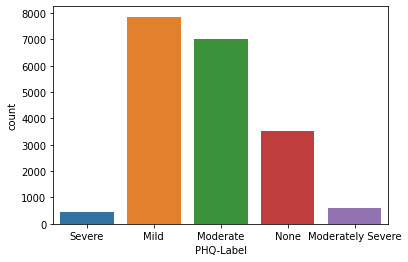

In [ ]:
sns.countplot(x='PHQ-Label',data=df)

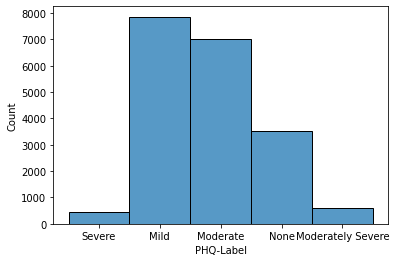

In [ ]:
sns.histplot(data=df, x="PHQ-Label")

In [ ]:
df.to_excel('processed_without_sampling.xlsx')
df2 = df.copy()

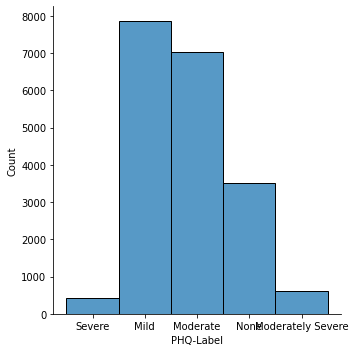

In [ ]:
sns.displot(df, x="PHQ-Label", discrete=True)

##OverSampling


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(['PHQ-Label','Email Address', 'UserId', 'Date_Time'], axis=1)
y = df['PHQ-Label']
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42)

In [ ]:
unique, count = np.unique(y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{'Mild': 5856,
 'Moderate': 5283,
 'Moderately Severe': 460,
 'None': 2654,
 'Severe': 322}

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
unique, count = np.unique(y_train_res, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{'Mild': 5856,
 'Moderate': 5856,
 'Moderately Severe': 5856,
 'None': 5856,
 'Severe': 5856}

In [ ]:
x_train_res['PHQ-Label'] = y_train_res

In [ ]:
oversampled = x_train_res.copy()
oversampled

,Age,ACCELEROMETER_X,ACCELEROMETER_Y,ACCELEROMETER_Z,BATTERY_LEVEL,Light_v,GRAV_X,GRAV_Y,GRAV_Z,GYROSCOPE_X,...,MAG_Y,MAG_Z,ORIENTATION_AZIMUTH,ORIENTATION_PITCH,ORIENTATION_ROLL,SENSORGPS_LATITUDE,SENSORGPS_LONGITUDE,Gender_Female,Gender_Male,PHQ-Label
0,22.5,0.052343,0.014656,9.738490,38.000000,0.000000,0.052664,0.022221,9.806480,-0.016722,...,32.531200,-27.431300,-0.246905,0.000000,0.000000,23.745100,90.365700,1,0,Mild
1,22.5,-0.275333,0.220267,9.938330,36.000000,0.000000,-0.247684,0.210693,9.801260,-0.000533,...,24.000000,-13.860000,-0.063097,0.000000,0.000000,23.741700,90.425600,0,1,None
2,22.5,-0.786255,0.150299,9.880080,100.000000,16.000000,-0.776674,0.136740,9.774890,-0.000214,...,11.532600,-21.661400,0.832905,0.000000,0.079412,23.699300,90.433600,0,1,Mild
3,22.5,-0.573411,-0.347758,9.731830,99.000000,1.271250,-0.580307,-0.349755,9.783220,0.000133,...,44.700800,-33.293800,-0.619271,0.000000,0.058853,23.743900,90.410400,0,1,Mild
4,22.5,0.399832,2.940080,9.600750,48.000000,0.000000,0.362660,2.855250,9.374780,0.012250,...,20.880000,-31.260000,0.092887,-0.296924,0.000000,23.741700,90.425600,0,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29275,22.5,5.254854,2.464781,-6.443326,92.842519,0.000000,5.206147,2.469533,-6.431084,0.002274,...,9.187167,20.091435,-0.582186,-0.493641,0.984102,23.762136,90.407261,0,1,Severe
29276,22.5,1.394215,9.973155,-0.450178,69.230795,0.000000,1.420926,9.608933,-0.519459,0.005613,...,-32.308330,31.826151,0.618533,-1.377860,-1.766608,23.831700,90.418620,1,0,Severe
29277,22.5,3.327318,5.266800,3.460143,23.100006,1.460258,3.234450,5.129195,3.610066,-0.005561,...,-6.330546,-39.256841,-0.052522,-0.632828,-1.004856,23.810433,90.413640,0,0,Severe
29278,22.5,-2.983774,7.688632,1.893389,44.176689,9.159020,-3.028247,7.739084,2.054892,-0.032838,...,-27.726801,29.072383,-0.692181,-0.918219,0.465177,23.785566,90.411137,0,0,Severe


In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize_columns(x):
  x[['ACCELEROMETER_X','ACCELEROMETER_Y', 'ACCELEROMETER_Z', 'BATTERY_LEVEL', 
    'Light_v', 'GRAV_X', 'GRAV_Y', 'GRAV_Z', 'GYROSCOPE_X', 'GYROSCOPE_Y',
    'GYROSCOPE_Z', 'MAG_X' , 'MAG_Y', 'MAG_Z',
    'ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL', 
    'SENSORGPS_LATITUDE', 'SENSORGPS_LONGITUDE', 'Age']] = StandardScaler().fit_transform(
        x[['ACCELEROMETER_X','ACCELEROMETER_Y', 'ACCELEROMETER_Z', 'BATTERY_LEVEL', 
    'Light_v', 'GRAV_X', 'GRAV_Y', 'GRAV_Z', 'GYROSCOPE_X', 'GYROSCOPE_Y',
    'GYROSCOPE_Z', 'MAG_X' , 'MAG_Y', 'MAG_Z',
    'ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL', 
    'SENSORGPS_LATITUDE', 'SENSORGPS_LONGITUDE', 'Age']])
  return x
oversampled = standardize_columns(oversampled)

In [ ]:
oversampled.to_excel('processed_and_oversampled.xlsx')

In [ ]:
print(5871*5)

29355


##Undersampled

In [ ]:
df['PHQ-Label'].value_counts()

Mild                 7861
Moderate             7026
None                 3509
Moderately Severe     606
Severe                432
Name: PHQ-Label, dtype: int64

In [ ]:
undersampled = df[df['PHQ-Label'] == 'Severe']
undersampled['PHQ-Label'].value_counts()

Severe    432
Name: PHQ-Label, dtype: int64

In [ ]:
def undersample_column(majority_col, undersampled):  
  minority_class_len = len(df[df['PHQ-Label'] == 'Severe' ])
  majority_class_indices = df[df['PHQ-Label'] == majority_col].index
  random_majority_indices = np.random.choice(majority_class_indices, minority_class_len, replace=False)
  minority_class_indices = df[df['PHQ-Label'] == 'Severe' ].index
  under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])
  under_sample1 = df.loc[under_sample_indices]
  under_sample1 = under_sample1[under_sample1['PHQ-Label']==majority_col]
  #print(under_sample1['PHQ-Label'].value_counts())
  undersampled = pd.concat([undersampled, under_sample1], ignore_index=True, sort=False )
  return undersampled

In [ ]:
majority_columns = ['None', 'Mild', 'Moderate',  'Moderately Severe']
for i in majority_columns:
  undersampled = undersample_column(i,undersampled)

undersampled['PHQ-Label'].value_counts()

Severe               432
None                 432
Mild                 432
Moderate             432
Moderately Severe    432
Name: PHQ-Label, dtype: int64

In [ ]:
undersampled = standardize_columns(undersampled)
undersampled.to_excel('processed_and_undersampled.xlsx')

In [ ]:
oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29280 entries, 0 to 29279
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  29280 non-null  float64
 1   ACCELEROMETER_X      29280 non-null  float64
 2   ACCELEROMETER_Y      29280 non-null  float64
 3   ACCELEROMETER_Z      29280 non-null  float64
 4   BATTERY_LEVEL        29280 non-null  float64
 5   Light_v              29280 non-null  float64
 6   GRAV_X               29280 non-null  float64
 7   GRAV_Y               29280 non-null  float64
 8   GRAV_Z               29280 non-null  float64
 9   GYROSCOPE_X          29280 non-null  float64
 10  GYROSCOPE_Y          29280 non-null  float64
 11  GYROSCOPE_Z          29280 non-null  float64
 12  MAG_X                29280 non-null  float64
 13  MAG_Y                29280 non-null  float64
 14  MAG_Z                29280 non-null  float64
 15  ORIENTATION_AZIMUTH  29280 non-null 

16.78195346510548 K.M


In [ ]:
df.reset_index(inplace=True)
df.head(5)

,index,UserId,Age,ACCELEROMETER_X,ACCELEROMETER_Y,ACCELEROMETER_Z,BATTERY_LEVEL,Date_Time,Light_v,GRAV_X,...,MAG_Z,ORIENTATION_AZIMUTH,ORIENTATION_PITCH,ORIENTATION_ROLL,SENSORGPS_LATITUDE,SENSORGPS_LONGITUDE,Email Address,PHQ-Label,Gender_Female,Gender_Male
0,0,34aHCNx4fvb5pyE4mPdbGTMXjPb2,22.5,-3.511770,5.972490,6.99871,25.0,"Mar 8, 2022 10:16:11 PM",17.010,-3.481910,...,-35.1970,0.875866,-0.651602,0.465065,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
1,1,34aHCNx4fvb5pyE4mPdbGTMXjPb2,22.5,-0.175872,3.080760,8.74457,24.0,"Mar 8, 2022 10:31:55 PM",17.010,0.368287,...,-29.1702,-0.615485,-0.338664,0.000000,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
2,2,34aHCNx4fvb5pyE4mPdbGTMXjPb2,22.5,2.298610,0.246461,9.57129,21.0,"Mar 8, 2022 11:17:02 PM",12.015,2.292660,...,0.3538,1.713230,0.000000,-0.235693,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
3,3,34aHCNx4fvb5pyE4mPdbGTMXjPb2,22.5,0.208176,8.001000,5.88275,19.0,"Mar 8, 2022 11:40:38 PM",0.000,0.206101,...,-0.0976,-2.862400,-0.936502,0.000000,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0
4,4,34aHCNx4fvb5pyE4mPdbGTMXjPb2,22.5,-2.880960,8.937790,3.71336,17.0,"Mar 8, 2022 11:55:38 PM",0.000,-3.130330,...,19.6054,-2.190090,-1.086690,0.659832,23.8317,90.4187,fabiha.efa@northsouth.edu,Severe,1,0


In [ ]:
len(df)

19434

In [ ]:
df3 = pd.read_excel('thesis_dataset.xlsx')

In [ ]:
count = 0
for i,j in df3[['SENSORGPS_LATITUDE', 'SENSORGPS_LONGITUDE']].iterrows():
  print(i, ' : ',j[0], j[1])
  count += 1
  if count is 10:
    break


0  :  23.8317 90.4187
1  :  23.8317 90.4187
2  :  23.8317 90.4187
3  :  23.8317 90.4187
4  :  23.8317 90.4187
5  :  23.8317 90.4187
6  :  23.8317 90.4187
7  :  23.8317 90.4187
8  :  23.8317 90.4187
9  :  23.8317 90.4187


In [ ]:
# print(df3['UserId'].nunique())
# count = 1
# for i in df3['UserId'].unique():
#   print(count, i)
#   count += 1

In [ ]:
#df3[df3['SENSORGPS_LONGITUDE'] == 90.41870 ][['SENSORGPS_LONGITUDE','SENSORGPS_LATITUDE']]

In [ ]:
count = 0
for i in df3['UserId'].unique():
  count += 1
  count2 = 0
  for  z, x, y in df3[df3['UserId'] == i ][['index','SENSORGPS_LONGITUDE','SENSORGPS_LATITUDE']].itertuples(index=False):
    print(z, x, y)
    count2 += 1
    if count2 is 1:
      break
  if count == 5:
    break



0 90.4187 23.8317
116 90.4093 23.7443
266 90.4075 23.7615
343 90.3612 23.7963
457 90.4186 23.8317


In [ ]:
df3['Distance Travelled'] = np.nan
df3['Movement'] = 'STATIONARY'

In [ ]:
df3.columns

Index(['Unnamed: 0', 'UserId', 'Entry_Id', 'Age', 'Gender', 'University',
       'ACCELEROMETER_X', 'ACCELEROMETER_Y', 'ACCELEROMETER_Z',
       'BATTERY_LEVEL', 'Date_Time', 'Light_v', 'GRAV_X', 'GRAV_Y', 'GRAV_Z',
       'GYROSCOPE_X', 'GYROSCOPE_Y', 'GYROSCOPE_Z', 'MAG_X', 'MAG_Y', 'MAG_Z',
       'ORIENTATION_AZIMUTH', 'ORIENTATION_PITCH', 'ORIENTATION_ROLL',
       'SENSORGPS_LATITUDE', 'SENSORGPS_LONGITUDE', 'Email Address',
       'PHQ-Label'],
      dtype='object')

In [ ]:
len(df)

22510

In [ ]:
zero = 0
nonzero = 0

for i in df3['UserId'].unique():
  count = 0
  sensorgps_lat = sensorgps_long = 0
  for  z, x, y in df3[df3['UserId'] == i ][['Unnamed: 0','SENSORGPS_LATITUDE','SENSORGPS_LONGITUDE']].itertuples(index=False):
    if count is 0:
      sensorgps_lat = x
      sensorgps_long = y      
    else:
      dist = distance(sensorgps_lat, x, sensorgps_long,y)
      df3.loc[z,'Distance Travelled'] = dist      
      if dist == 0:
        zero += 1
        df3.loc[ df3['Unnamed: 0'] == z,'Movement'] = 'STATIONARY'
      else:
        nonzero += 1
        df3.loc[df3['Unnamed: 0'] == z,'Movement'] = 'MOVING'
      sensorgps_lat = x
      sensorgps_long = y
    count += 1

print(zero, nonzero)





21042 1729


In [ ]:
df['index'].nunique()

19434

In [ ]:
df.to_excel('test.xlsx')

In [ ]:
df['Date_Time'] =  pd.to_datetime(df3['Date_Time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22510 entries, 0 to 22850
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                19434 non-null  float64       
 1   UserId               19434 non-null  object        
 2   Age                  19434 non-null  float64       
 3   ACCELEROMETER_X      19434 non-null  float64       
 4   ACCELEROMETER_Y      19434 non-null  float64       
 5   ACCELEROMETER_Z      19434 non-null  float64       
 6   BATTERY_LEVEL        19434 non-null  float64       
 7   Date_Time            19434 non-null  datetime64[ns]
 8   Light_v              19434 non-null  float64       
 9   GRAV_X               19434 non-null  float64       
 10  GRAV_Y               19434 non-null  float64       
 11  GRAV_Z               19434 non-null  float64       
 12  GYROSCOPE_X          19434 non-null  float64       
 13  GYROSCOPE_Y          19434 non-

In [ ]:
print(df['Date_Time'].dt.time)

0        22:16:11
1        22:31:55
2        23:17:02
3        23:40:38
4        23:55:38
           ...   
22844         NaT
22846         NaT
22847         NaT
22849         NaT
22850         NaT
Name: Date_Time, Length: 22510, dtype: object


In [ ]:
print(df['Date_Time'].dt.strftime('%H:%M'))

0        22:16
1        22:31
2        23:17
3        23:40
4        23:55
         ...  
22844      NaN
22846      NaN
22847      NaN
22849      NaN
22850      NaN
Name: Date_Time, Length: 22510, dtype: object


In [ ]:
s = 100000
print(s/3600)

27.77777777777778


In [ ]:
import pandas as pd

# Create your Pandas DataFrame
d = {'username': ['Alice', 'Bob', 'Carl', 'catty'],
     'age': [18, 22, 43, 20],
     'income': [100000, 98000, 111000, 50000]}
df = pd.DataFrame(d)

print(df)

print(df.var())

print(df.var()['income'])
print(df.var()['age'])

  username  age  income
0    Alice   18  100000
1      Bob   22   98000
2     Carl   43  111000
3    catty   20   50000
age       1.349167e+02
income    7.349167e+08
dtype: float64
734916666.6666666
134.91666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
